In [6]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Functions and stuff

In [7]:
class preProc():

    def __init__(self):
        self.image_list = []
        self.roi = np.empty([1,1])

    def list_files(self, dir, fileformat = ".png"):
        r = []
        for root, dirs, files in os.walk(dir):
            for name in files:
                if name.endswith(fileformat):
                    self.image_list.append(os.path.join(root, name))
        return self.image_list

    def nonDepth(list):
        
        return

pp = preProc()

## Loading the image in and cropping

(640, 640, 3)


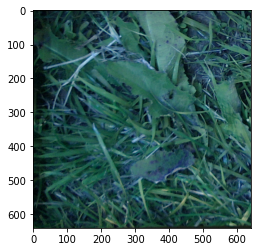

In [8]:
dir = "/home/bbejczy/repos/GALIROOT/data/l515_imgs/"
images = pp.list_files(dir)

img = cv2.imread(images[7])
# pp.roi = img[365:1000 , 340:1120]
pp.roi = img[360:1000, 340:980]
print(pp.roi.shape)
hsv_roi = cv2.cvtColor(pp.roi, cv2.COLOR_BGR2HSV)
plt.imshow(pp.roi)


## Odd input for maxpool

Testing ```ceil_mode=True``` creates a value of the last coloumns/rows even if not all entries of the kernel all filled.

In [9]:
import torch.nn as nn
import torch

x = torch.randn(1,3,37,46)
# x = torch.tensor([[1,1,1,1,1], [1,2,2,2,1], [1,2,3,2,1], [1,2,2,2,1], [1,1,1,1,1]]).float()
# x = x.unsqueeze(0)
y_1 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0)
y_2 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0, ceil_mode=True)
conv = nn.Conv2d(3,32,1)
print(x.shape)
print(y_1(conv(x)).shape)
print(y_2(conv(x)).shape)

torch.Size([1, 3, 37, 46])
torch.Size([1, 32, 18, 23])
torch.Size([1, 32, 19, 23])


In [10]:
import matplotlib.pyplot as plt
import loader
from models import Net
import torch
from torchvision import transforms
import torch.nn as nn
from pathlib import Path
import numpy as np

img = '/home/bbejczy/repos/GALIROOT/data/20200809_skaevinge_pruned/img/'
ann = '/home/bbejczy/repos/GALIROOT/data/20200809_skaevinge_pruned/ann/'
model = '/home/bbejczy/repos/GALIROOT/models/baseline_v1.pt'

Dataset = loader.KeypointsDataset(img_dir=Path(img), annotations_dir=Path(ann))

data_load = torch.utils.data.DataLoader(
    Dataset
)

def show_keypoints(image, key_pts, pred):
    """Show image with keypoints"""
    print(image.shape)
    image = transforms.ToPILImage()(image).convert('RGB')
    print(type(image))
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    plt.scatter(pred[:, 0], pred[:, 1], s=20, marker='.', c='b')


In [11]:
net = Net()

net.load_state_dict(torch.load(model))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=211968, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Predicted stem:  tensor([[302.8767, 133.6294]], grad_fn=<AddmmBackward>)
torch.Size([3, 635, 775])
<class 'PIL.Image.Image'>


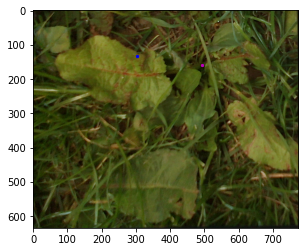

In [23]:
rand_i = np.random.randint(0, len(data_load))
sample = Dataset[rand_i]
prediction = net.forward(sample['image'].unsqueeze(0))
print("Predicted stem: ", prediction)

show_keypoints(sample['image'], sample['keypoint'], prediction.detach().numpy())